## Data **preparation**



In [1]:
!pip install beautifulsoup4==4.12.3 requests==2.32.3 wordcloud==1.9.3 matplotlib==3.9.0 pandas==2.2.2
!pip install -qU transformers==4.41.2 torch==2.3.1 datasets==2.20.0 gdcm==1.1 pydicom==2.4.4 pinecone-client==4.1.1
!pip install openai==1.34.0
!pip install open_clip_torch==2.24.0
!pip install huggingface_hub==0.23.4

from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import open_clip
import pandas as pd
import torch
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from huggingface_hub.hf_api import HfFolder, RepositoryNotFoundError
from matplotlib import pyplot as plt, image as mpimg
from os import getenv
from sklearn.metrics.pairwise import cosine_similarity
# from collections import OrderedDict
# from io import BytesIO
# import IPython.display
# from PIL import Image
# import requests
# from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer


# CLIP

In [3]:
# Load hugging face data and
token = getenv("HF_TOKEN", None)

if token is not None:
    HfFolder.save_token(token)

try:
    dataset_all = load_dataset("kvriza8/microscopy_images", token=token)
except RepositoryNotFoundError as e:
    if token is None:
        raise ValueError("The repository could not be found. It may be private and you would need to provide your HuggingFace token in the \"HF_TOKEN\" environment variable.")
    print(e)
    
all_images, all_prompts, all_prompt_summaries = dataset_all["train"]["image"], dataset_all["train"]["caption"], dataset_all["train"]["caption_summary"]
image_data_df = pd.DataFrame(data={"images": all_images, "caption": all_prompts, "caption_summary": all_prompt_summaries})
image_data_df.head()

Generating train split:   0%|          | 0/20936 [00:00<?, ? examples/s]

,images,caption,caption_summary
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,EBSD inverse-pole maps of SLM from cross-secti...,"['EBSD', 'inverse-pole maps', 'SLM']"
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Electron backscatter diffraction (EBSD) invers...,"['EBSD', 'inverse-pole maps']"
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'microscopy', 'HIP']"
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Morphology of HEA raw powder.,"['morphology', 'HEA', 'raw powder']"
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'bright-field', 'CR sample']"


In [4]:
# This will download the file to the current directory
filepath = hf_hub_download(repo_id="kvriza8/clip-microscopy-50-epoch-captions", filename="open_clip_pytorch_model.bin")

print(f"Downloaded to: {filepath}.")

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloaded to: /root/.cache/huggingface/hub/models--kvriza8--clip-microscopy-50-epoch-captions/snapshots/7037bef9f9b89e64e99c3a847aa331a64c6265a5/open_clip_pytorch_model.bin.


In [5]:
# Loading the pretrained microscopy CLIP
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained=filepath)
tokenizer = open_clip.get_tokenizer("ViT-B-32")

In [6]:
def process_in_batches(images, texts, model, tokenizer, batch_size=32):
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size

    all_image_features = []
    all_text_features = []

    for i in range(num_batches):
        batch_images = images[i*batch_size : (i+1)*batch_size]
        batch_texts = texts[i*batch_size : (i+1)*batch_size]

        image_input = torch.tensor(np.stack(batch_images))
        text_tokens = tokenizer([desc for desc in batch_texts])

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            text_features = model.encode_text(text_tokens).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        all_image_features.append(image_features)
        all_text_features.append(text_features)

    # Concatenate all batch results
    all_image_features = torch.cat(all_image_features, dim=0)
    all_text_features = torch.cat(all_text_features, dim=0)

    return all_image_features, all_text_features

In [7]:
images = []
texts = []
original_images = []

for idx, image in enumerate(all_images):
  original_images.append(image.convert("RGB"))
  images.append(preprocess(image.convert("RGB")))
  texts.append(all_prompts[idx])

all_image_features, all_text_features = process_in_batches(images, texts, model, tokenizer, batch_size=32)

In [8]:
print(f"{len(all_image_features):,}")

20,936


In [9]:
img_embeddings = [i.cpu().detach().numpy() for i in all_image_features]
text_embeddings = [i.cpu().detach().numpy() for i in all_text_features]
image_data_df["img_embeddings"] = img_embeddings
image_data_df["text_embeddings"] = text_embeddings
image_data_df["image"] = image_data_df["images"]

In [10]:
image_data_df["index"] = np.arange(len(image_data_df))

In [11]:
image_data_df.head()

,images,caption,caption_summary,img_embeddings,text_embeddings,image,index
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,EBSD inverse-pole maps of SLM from cross-secti...,"['EBSD', 'inverse-pole maps', 'SLM']","[0.003523392, 0.012981293, -0.06411135, -0.063...","[-0.023630882, 0.011572786, -0.04518867, -0.00...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Electron backscatter diffraction (EBSD) invers...,"['EBSD', 'inverse-pole maps']","[0.0028608348, 0.047516633, -0.04749314, -0.04...","[-0.036105797, 0.018760972, -0.09379338, -0.02...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'microscopy', 'HIP']","[-0.02125321, -0.002723787, 0.0629143, 0.01429...","[0.004127441, 0.04852128, 0.05200335, -0.00154...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Morphology of HEA raw powder.,"['morphology', 'HEA', 'raw powder']","[-0.008284678, -0.021394674, 0.011646928, -0.0...","[-0.0002535032, -0.04777808, 0.033700135, -0.0...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,3
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,A bright-field transmission electron microscop...,"['TEM', 'bright-field', 'CR sample']","[0.07367363, 0.061459213, 0.04125241, -0.02043...","[-0.00076458376, 0.06604647, 0.0709117, -0.003...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,4


In [12]:
def plot_images(images):
    for image in images:
        plt.imshow(image)
        plt.show()

def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    # list_images = [top_images.iloc[idx].image for idx in index_values]
    # list_captions = [top_images.iloc[idx].caption_summary for idx in index_values]
    # similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]
    
    # Using map generators will reduce the amount of memory needed
    list_images = map(lambda idx: top_images.iloc[idx].image, index_values)
    list_captions = map(lambda idx: top_images.iloc[idx].caption_summary, index_values)
    similarity_score = map(lambda idx: top_images.iloc[idx].cos_sim, index_values)

    n_row = n_col = 2
    
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
        img1 = img #mpimg.imread(img)
        ax.imshow(img1)
        ax.axis('off')  #
        sim_score = 100 * float(f"{sim_score:.2f}")
        ax.title.set_text(f"Caption keywords: {caption}")
        #\nSimilarity: {sim_score}%")
    
    plt.show()

In [13]:
def get_single_text_embedding(texts, model, tokenizer, batch_size=1):
    num_images = 1
    num_batches = (num_images + batch_size - 1) // batch_size
    all_text_features = []

    for i in range(num_batches):
        batch_texts = texts[i * batch_size:(i + 1) * batch_size]
        text_tokens = tokenizer([desc for desc in batch_texts])

        with torch.no_grad():
            text_features = model.encode_text(text_tokens).float()

        text_features /= text_features.norm(dim=-1, keepdim=True)
        all_text_features.append(text_features)

    # Concatenate all batch results
    all_text_features = torch.cat(all_text_features, dim=0)
    return  all_text_features

In [14]:
def get_single_image_embedding(images, model, batch_size=1):
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size

    all_image_features = []

    for i in range(num_batches):
        batch_images = images[i * batch_size:(i + 1) * batch_size]
        image_input = torch.tensor(np.stack(batch_images))

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)

    # Concatenate all batch results
    all_image_features = torch.cat(all_image_features, dim=0)

    return all_image_features

In [15]:
def get_top_N_images(query, data, top_N=4, search_criterion="text"):

    """
    Retrieve top_N (4 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query, model, tokenizer, batch_size=1)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query, model, batch_size=1)

    # Relevant columns
    relevant_cols = ["caption_summary", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect.reshape(1, -1), x.reshape(1, -1)))
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by="cos_sim", ascending=False)[1:top_N + 1]

    return most_similar_articles[relevant_cols].reset_index()

In [16]:
query_caption = "EDS mapping"

In [17]:
top_images = get_top_N_images(query_caption, image_data_df)
print(f"Query: {query_caption}")
top_images

Query: EDS mapping


,index,caption_summary,image,cos_sim
0,13287,"['EDXS', 'elemental mapping', 'materials scien...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.689311
1,11937,"['Element mapping', 'Se', 'Characterization']",<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.683976
2,13288,"['EDXS', 'elemental mapping', 'materials scien...",<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.681020
3,7284,"['DAPI', 'nuclei', 'blue']",<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.662930


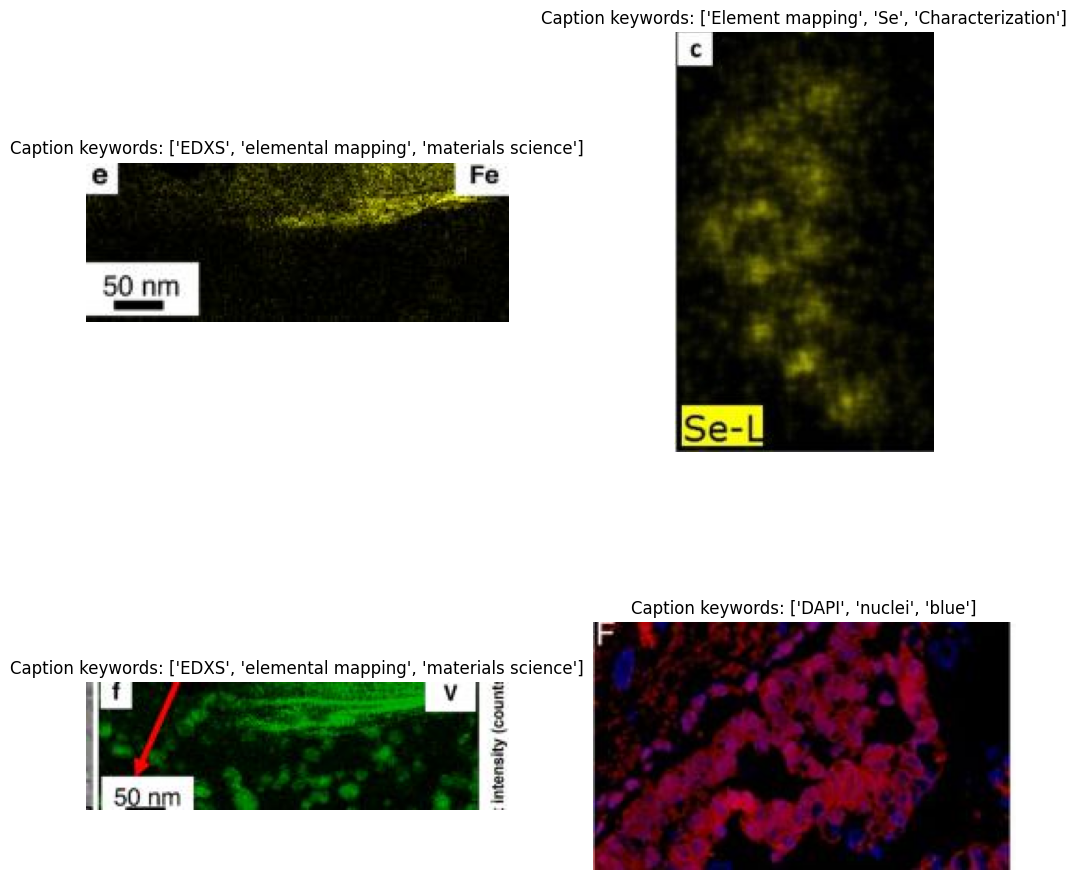

In [18]:
plot_images_by_side(top_images)